In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold

from statistics import mean
import random
import csv
import time

import matplotlib.pyplot as plt

from loadData import getTrainAndTestData
from preprocess import segmentation
from utility import plot_confusion_matrix, plot_loss

## Constants 

In [2]:
DANCE_MOVES = ['snake','mermaid', 'cowboy', 'jamesbond', 'logout2',
               'dab', 'window360', 'scarecrow', 'pushback']

IN_FEATURES = 300
OUT_FEATURES = 9
HIDDEN_LAYER_1_NODES = 150 #100
HIDDEN_LAYER_2_NODES = 60 # 20

K = 3 # 12
EPOCHS = 100
TRAIN_BATCH_SIZE = 108
TEST_BATCH_SIZE = 40
LEARNING_RATE = 0.01

NUM_TO_DANCE_MAP = {0: 'dab', 1: 'jamesbond', 2: 'mermaid', 
                    3: 'scarecrow', 4:'pushback',  5: 'cowboy', 
                    6: 'window360', 7: 'snake', 8:'logout2'}


## Load Dataset

In [3]:
raw_train_df, raw_test_df = getTrainAndTestData()
training_X, lbl_train = segmentation(raw_train_df)
testing_X, lbl_test = segmentation(raw_test_df)

print("Input Training vector shape :", training_X.shape)
print("Input Training label shape :", lbl_train.shape)
print("Testing vector shape :", testing_X.shape)
print("Testing label shape :", lbl_test.shape)

X_train = torch.FloatTensor(training_X)
X_test = torch.FloatTensor(testing_X)
y_train = torch.LongTensor(lbl_train)
y_test = torch.LongTensor(lbl_test)

Input Training vector shape : (4679, 300)
Input Training label shape : (4679,)
Testing vector shape : (1079, 300)
Testing label shape : (1079,)


## Multi-Layer Perceptron Model

In [4]:
class Model(nn.Module):
    def __init__(self, in_features, h1, h2, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)            # hidden layer
        self.out = nn.Linear(h2, out_features)  # output layer
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

#### Instantiate Model class using default parameters

In [5]:
torch.manual_seed(32)
mlp = Model(in_features=IN_FEATURES, h1=HIDDEN_LAYER_1_NODES, h2=HIDDEN_LAYER_2_NODES, out_features=OUT_FEATURES)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=LEARNING_RATE)

#### 10-fold Stratified Cross Validation 

In [6]:
skfcv = StratifiedKFold(n_splits=K, shuffle=True, random_state=1)
training_loss = {}
val_acc = []

# per fold 
for fold, (train_index, test_index) in enumerate(skfcv.split(X_train, y_train)):
    x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    train_combined = TensorDataset(x_train_fold, y_train_fold)
    test_combined = TensorDataset(x_test_fold, y_test_fold)
    trainloader = DataLoader(train_combined, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
    testloader = DataLoader(test_combined, batch_size=TEST_BATCH_SIZE, shuffle=False)
    # per epoch
    for i in range(EPOCHS): 
        i+=1
        # per batch 
        losses = [] 
        val_correct_preds = 0
        count = 0 
        for batch_idx, (data, target) in enumerate(trainloader):
            mlp.train()
             
            # training 
            y_pred = mlp.forward(data)
            loss = criterion(y_pred, target)
            losses.append(loss)
            
            # backtracking 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 
        
        # validating 
        with torch.no_grad():
            mlp.eval()
            for val_batch_idx, (val_data, val_target) in enumerate(testloader):
                y_out = mlp.forward(val_data)
                for row in range(y_out.shape[0]):
                    if y_out[row].argmax() == val_target[row]:
                        val_correct_preds += 1
                    count += 1
                    
    # per fold         
    with torch.no_grad():
        training_loss[fold] = np.array(losses).mean()
        print("-----------------------")
        print(f"fold: {fold} , training_loss: {training_loss[fold]}")
        print(f"fold: {fold}, {val_correct_preds} out of {count} = {100*val_correct_preds/count:.2f}% correct")
        print("-----------------------")
        val_acc.append(100*val_correct_preds/count)
        count = 0

print()
print("Done Training")
print("Max Validation Accuracy: ",  np.array(val_acc).max())

-----------------------
fold: 0 , training_loss: 0.0016845890786498785
fold: 0, 1509 out of 1560 = 96.73% correct
-----------------------
-----------------------
fold: 1 , training_loss: 0.0002559666463639587
fold: 1, 1553 out of 1560 = 99.55% correct
-----------------------
-----------------------
fold: 2 , training_loss: 0.00011113067739643157
fold: 2, 1552 out of 1559 = 99.55% correct
-----------------------

Done Training
Max Validation Accuracy:  99.55128205128206


#### Mean Loss per fold 

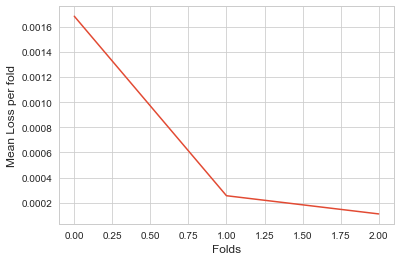

In [7]:
with torch.no_grad():
    y_axis  = training_loss.values()
    plot_loss(K,y_axis)

## Evaluation 

In [8]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    start_time = time.time()
    y_val = mlp.forward(X_test)
    print("--- %s execution time in seconds ---" % (time.time() - start_time))
    loss = criterion(y_val, y_test)
    print(f'Loss with test set : {loss:.8f}')

--- 0.035830020904541016 execution time in seconds ---
Loss with test set : 6.82507753



757 out of 1079 = 70.16% correct
Confusion matrix, without normalization
tensor([[118,   0,   0,   0,   0,   0,   1,   0,   1],
        [  0, 120,   0,   0,   0,   0,   0,   0,   0],
        [ 35,   0,  81,   0,   0,   0,   2,   2,   0],
        [  0,   0,   0, 120,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0, 114,   6,   0,   0,   0],
        [  0,   0,   0,   0,  43,  74,   0,   3,   0],
        [  0,  54,   0,   0,   0,   0,  49,   1,  15],
        [  0,   0,   0,   0,   0,   0,  40,  80,   0],
        [ 93,   0,  20,   0,   0,   0,   1,   5,   1]])
Classification Report for MLP :
              precision    recall  f1-score   support

           0       0.48      0.98      0.64       120
           1       0.69      1.00      0.82       120
           2       0.80      0.68      0.73       120
           3       1.00      1.00      1.00       120
           4       0.73      0.95      0.82       120
           5       0.93      0.62      0.74       120
           6       

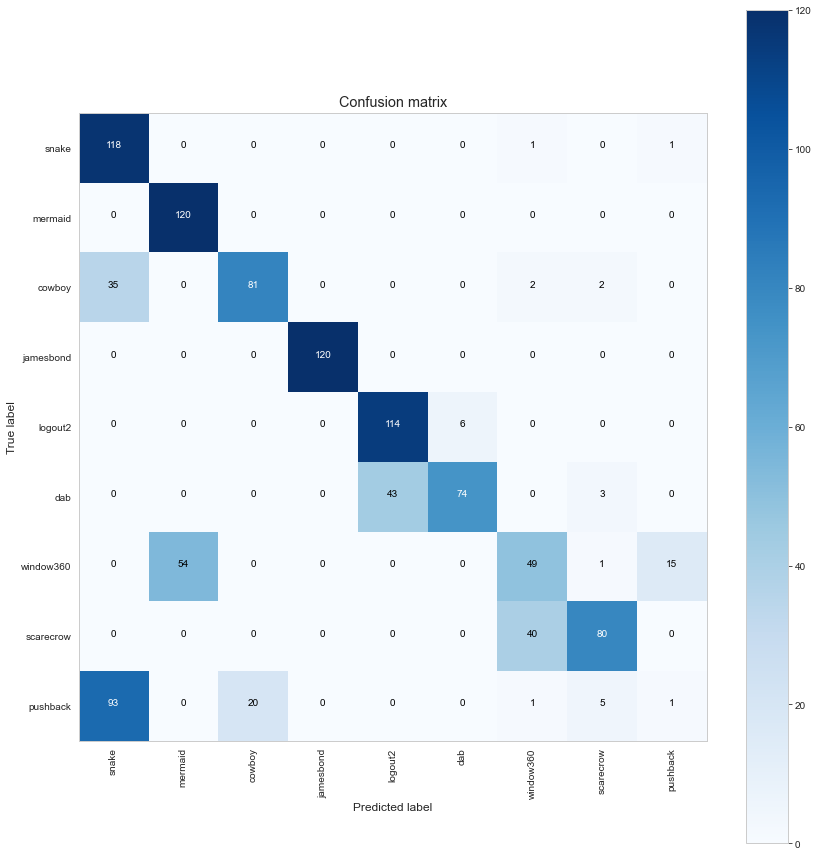

In [9]:
with torch.no_grad():
    # checking accuracy on test dataset 
    preds = []
    correct = 0
    for i,data in enumerate(X_test):
        y_val = mlp.forward(data)
        preds.append(y_val.argmax().item())
        if y_val.argmax().item() == y_test[i]:
            correct += 1
    print(f'\n{correct} out of {len(y_test)} = {100*correct/len(y_test):.2f}% correct')
    y_preds = torch.tensor(preds, dtype = torch.int64)
    stacked = torch.stack((y_test,y_preds),dim=1)

    # confusion matrix generation 
    cmt = torch.zeros(OUT_FEATURES,OUT_FEATURES, dtype=torch.int64)
    for p in stacked:
        tl, pl = p.tolist()
        cmt[tl, pl] = cmt[tl, pl] + 1  
    
    plt.figure(figsize=(12,12))
    plot_confusion_matrix(cmt, DANCE_MOVES)
    
    print("Classification Report for MLP :")
    print(classification_report(y_test, y_preds))

In [10]:
# model weights 
with torch.no_grad():
    mlp_params = {}
    for name, param in mlp.named_parameters():
        mlp_params[name] = param.numpy().copy().tolist()
        
    print(mlp_params.keys())
    for key in mlp_params.keys(): 
        print(f"{key} : {len(mlp_params[key])} neurons in {key} layer")
        print(f" number of connections  : {len(mlp_params[key])} * {np.asarray(mlp_params[key][len(mlp_params[key]) -1]).size} = {len(mlp_params[key]) * np.asarray(mlp_params[key][len(mlp_params[key]) -1]).size } ")

    # save model weights 
    with open('mlp.csv', 'w') as csv_file:  
        writer = csv.writer(csv_file)
        for key, value in mlp_params.items():
           writer.writerow([key, value])

dict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'out.weight', 'out.bias'])
fc1.weight : 150 neurons in fc1.weight layer
 number of connections  : 150 * 300 = 45000 
fc1.bias : 150 neurons in fc1.bias layer
 number of connections  : 150 * 1 = 150 
fc2.weight : 60 neurons in fc2.weight layer
 number of connections  : 60 * 150 = 9000 
fc2.bias : 60 neurons in fc2.bias layer
 number of connections  : 60 * 1 = 60 
out.weight : 9 neurons in out.weight layer
 number of connections  : 9 * 60 = 540 
out.bias : 9 neurons in out.bias layer
 number of connections  : 9 * 1 = 9 


## Save & Load Model

In [11]:
torch.save(mlp.state_dict(), 'MLPW9.pt')
loaded_model = Model(in_features=IN_FEATURES,h1=HIDDEN_LAYER_1_NODES, h2=HIDDEN_LAYER_2_NODES, out_features=OUT_FEATURES) 
loaded_model.load_state_dict(torch.load('MLPW9.pt'))
loaded_model.eval()

Model(
  (fc1): Linear(in_features=300, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=9, bias=True)
)

In [12]:
# loss when loaded model is run on test dataset 
with torch.no_grad():
    y_val = loaded_model.forward(X_test)
    loss = criterion(y_val, y_test)
    print(f'{loss:.8f}')

6.82507753


In [13]:
# run model on a random sample row of the test dataset 
random.seed(899)
random_int = random.randint(0, len(testing_X))
random_input = torch.FloatTensor(testing_X[random_int])
print(random_input)
print(random_input.shape)

# random_input = torch.FloatTensor([])

with torch.no_grad():
    print(loaded_model(random_input))
    print()
    print(loaded_model(random_input).max())
    print(loaded_model(random_input).argmax().item())
    print(f"Predicted Output: {NUM_TO_DANCE_MAP[loaded_model(random_input).argmax().item()]}")
    print(f"Actual Output: {NUM_TO_DANCE_MAP[y_test[random_int].item()]}")

tensor([-4.2725e-04, -4.2725e-04, -4.2725e-04, -4.2725e-04, -4.2725e-04,
        -7.3242e-04, -1.0986e-03, -3.4485e-03, -3.4485e-03, -3.1433e-03,
        -3.1433e-03, -3.2043e-03, -3.2043e-03, -2.9297e-03, -1.7700e-03,
        -4.8828e-04, -3.3569e-04, -3.3569e-04, -3.3569e-04, -9.1553e-05,
        -6.1035e-05, -6.1035e-05, -3.6621e-04, -6.1035e-04, -1.4648e-03,
        -2.5940e-03, -3.6926e-03, -5.8594e-03, -6.0120e-03, -6.0120e-03,
        -6.0120e-03, -6.0120e-03, -6.1951e-03, -6.1951e-03, -5.5542e-03,
        -3.0212e-03, -2.4414e-04,  1.3733e-03,  2.5330e-03,  3.2959e-03,
         3.2959e-03,  2.5024e-03,  2.0142e-03,  1.4038e-03, -1.2207e-04,
        -3.9368e-03, -5.0964e-03, -5.0964e-03, -5.0964e-03, -4.9438e-03,
        -4.6997e-03, -3.0518e-03, -3.0518e-03, -4.1199e-03, -4.3945e-03,
        -4.3945e-03, -3.7842e-03, -3.4485e-03, -2.0142e-03, -7.0190e-04,
         2.9907e-03,  2.9907e-03,  2.9907e-03,  2.9907e-03,  3.0212e-03,
         3.5095e-03,  4.7607e-03,  5.5542e-03,  6.8

In [14]:
# save test dataset
with torch.no_grad(): 
    x = X_test.numpy().copy().tolist()
    np.savetxt("X_test.csv", x, delimiter=",")
    y = y_test.numpy().copy().tolist()
    np.savetxt("y_test.csv", y, delimiter=",")